# LiPo Visualization
This notebook demonstrates how to visualize raw action chunks, linearly blended actions, and optimized actions using the `ActionLiPo` class. It also shows the inference delay and blending zone using shaded regions.


In [1]:
#install matplotlib if not already installed
# pip install matplotlib

# This script demonstrates how to visualize the action of a LiPo battery using matplotlib
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from action_lipo import ActionLiPo

## Matplotlib Style Configuration

In [2]:
mpl.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

## Initialize Parameters and Load Action Chunks
Here we define chunk size, blending horizon, and delay, then initialize the optimizer and load the action data.

In [3]:
chunk = 50
blend = 10
time_delay = 3
lipo = ActionLiPo(chunk_size=chunk, blending_horizon=blend, len_time_delay=time_delay)

action_chunks = np.load('data/log_inference_actions.npy', allow_pickle=True)

## Plotting the Action Chunks and Optimization Results
This part loops through the action chunks and performs optimization and blending, then visualizes the result.

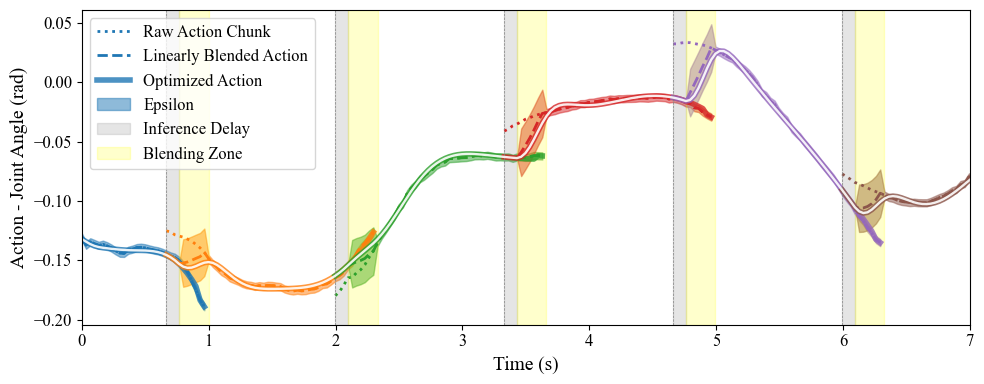

Number of logs: 8
Average solved time: 0.0143 seconds, Std: 0.0022 seconds


In [4]:
fig = plt.figure(figsize=(10, 4))
cmap = plt.get_cmap('tab10')
dt = 0.0333
prev_chunk = None
epsilon_blend = lipo.epsilon_blending
epsilon_path = lipo.epsilon_path
joint_index = 0
start_index = 3
bias_time = 4.5 * (chunk-blend) * dt

solved_stack = []
t_stack = []

for k in range(start_index, len(action_chunks) // chunk):
    c_idx = k - start_index - 1
    start_time = k * (chunk-blend) * dt - bias_time
    delay_time = time_delay * dt
    blending_time = blend * dt
    
    end_time = start_time + (chunk-blend) * dt - bias_time
    action_chunk = action_chunks[k * chunk:(k + 1) * chunk]
    x = np.arange(len(action_chunk)) * dt + start_time
    plt.plot(x, action_chunk[:,joint_index], label=f'Chunk',  linestyle=':', linewidth=2, color=cmap(c_idx))
    
    solved, blended = lipo.solve(action_chunk, prev_chunk, len_past_actions=blend if prev_chunk is not None else 0)
    solved_stack.append(solved[:chunk-blend, :])
    t_stack.append(np.arange(len(solved[:chunk-blend, :])) * dt + start_time)
    
    plt.plot(x, blended[:,joint_index], label=f'Blended', linestyle='--', linewidth=2, color=cmap(c_idx))
    plt.plot(x, solved[:,joint_index], label=f'Solved', linestyle='-', linewidth=4, color=cmap(c_idx), alpha=0.8)
    
    epsilons = np.concatenate([
        np.full(time_delay+1, 0),
        np.full(blend-time_delay-1, epsilon_blend),
        np.full(len(blended) - blend, epsilon_path)
    ])
    
    time_vals = np.arange(len(blended)) * dt + start_time
    y_vals = blended[:, joint_index]
    
    plt.fill_between(time_vals, y_vals - epsilons, y_vals + epsilons, 
                     color=cmap(c_idx), alpha=0.5)
    
    plt.axvspan(start_time, start_time + delay_time, color='gray', alpha=0.2)
    plt.axvspan(start_time + delay_time, start_time + blending_time, color='yellow', alpha=0.2)

    plt.axvline(x=start_time, color='gray', linestyle='--', linewidth=0.5)
    prev_chunk = solved.copy()

solved_stack = np.concatenate(solved_stack, axis=0)
t_stack = np.concatenate(t_stack, axis=0)
plt.plot(t_stack, solved_stack[:, joint_index], label='Optimized Action', linestyle='-', linewidth=1.7, color='white', alpha=0.9)

plt.xlim(0, 7)
plt.xlabel('Time (s)')
plt.ylabel('Action - Joint Angle (rad)')

plt.legend(['Raw Action Chunk', 'Linearly Blended Action', 'Optimized Action', 'Epsilon', 'Inference Delay', 'Blending Zone'], loc='upper left')
plt.tight_layout()
plt.show()

plt.close(fig)

lipo.print_solved_times()